In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np

In [22]:
df = pd.read_csv('/content/layoffs_data(3).csv')

In [23]:
df.dropna(inplace = True)
df.isna().mean()

Company                       0.0
Location_HQ                   0.0
Industry                      0.0
Percentage                    0.0
Date                          0.0
Source                        0.0
Funds_Raised                  0.0
Stage                         0.0
Date_Added                    0.0
Country                       0.0
Laid_Off_Count                0.0
List_of_Employees_Laid_Off    0.0
dtype: float64

In [24]:
# These columns don't have much use in our analysis
df.drop(columns = ['List_of_Employees_Laid_Off', 'Source', 'Date_Added'], inplace = True)

df.rename(columns = {'Laid_Off_Count': 'Layoffs'}, inplace = True)

In [25]:
df.describe()

,Percentage,Funds_Raised,Layoffs
count,1469.00000,1469.000000,1469.000000
mean,0.21701,797.049936,268.196732
std,0.20419,4921.209182,833.055963
min,0.00000,0.000000,3.000000
25%,0.10000,65.000000,40.000000
50%,0.15000,190.000000,86.000000
75%,0.27000,500.000000,200.000000
max,1.00000,121900.000000,12000.000000


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1469 entries, 1 to 3483
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Company       1469 non-null   object 
 1   Location_HQ   1469 non-null   object 
 2   Industry      1469 non-null   object 
 3   Percentage    1469 non-null   float64
 4   Date          1469 non-null   object 
 5   Funds_Raised  1469 non-null   float64
 6   Stage         1469 non-null   object 
 7   Country       1469 non-null   object 
 8   Layoffs       1469 non-null   float64
dtypes: float64(3), object(6)
memory usage: 114.8+ KB


In [27]:
def detect_outliers(df, column_names):
    """
    Detect outliers in the specified columns of a DataFrame and visualize the results.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - column_names (list): A list of column names to analyze for outliers.

    Returns:
    - pd.DataFrame: A DataFrame containing information about outliers for each specified column.
      Columns: ['Column', 'Number of Outliers', '% Outliers', 'Lower Limit', 'Upper Limit']
    """

    # Calculate the number of columns and rows for subplots
    col_len = len(column_names)
    num_columns = min(col_len, 3)
    num_rows = 2 * ((col_len + num_columns - 1) // num_columns)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(5 * num_columns, 3 * num_rows), squeeze = False)

    # Initialize a list to store outlier information for each column
    outlier_data = []

    # Iterate over column_names and create subplots
    for i, column_name in enumerate(column_names):
        data = df[column_name]

        # Calculate quartiles and interquartile range using np.percentile
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1

        # Define lower and upper limits for outlier detection
        low_lim, upp_lim = q1 - 1.5 * iqr, q3 + 1.5 * iqr

        # Find and display outliers
        outliers = df[(data < low_lim) | (data > upp_lim)][column_name]
        num_outliers = len(outliers)
        percent_outliers = round(num_outliers / len(df) * 100, 1)

        # Append outlier information to the list
        outlier_data.append([column_name, num_outliers, percent_outliers, round(low_lim, 1), round(upp_lim, 1)])

        # Calculate row and column indices for plotting
        row_index, col_index = divmod(i, num_columns * 2)

        # Create a boxplot to visualize the distribution and detect outliers
        ax_box, ax_hist = axes[row_index, col_index], axes[row_index + 1, col_index]
        sns.boxplot(x = data, ax = ax_box)
        ax_box.set(title = column_name.capitalize(), xlabel = None)
        ax_box.axvline(low_lim, color = 'red', linestyle = '--', label = f'Lower Limit: {low_lim:.1f}')
        ax_box.axvline(upp_lim, color = 'red', linestyle = '--', label = f'Upper Limit: {upp_lim:.1f}')
        ax_box.legend()

        # Create a histogram below the boxplot
        sns.histplot(data, bins = 20, ax = ax_hist, color = '#FF8C00')
        ax_hist.set(xlabel = None)
        ax_hist.set_yscale('log')  # Set y-axis scale to logarithmic
        ax_hist.set_ylabel(None)  # Disable y-axis label

    # Display the subplots
    plt.tight_layout()
    plt.show()

    # Combine the outlier information into a DataFrame
    outlier_df = pd.DataFrame(outlier_data, columns = ['Column', 'Number of Outliers', '% Outliers', 'Lower Limit', 'Upper Limit'])
    return outlier_df

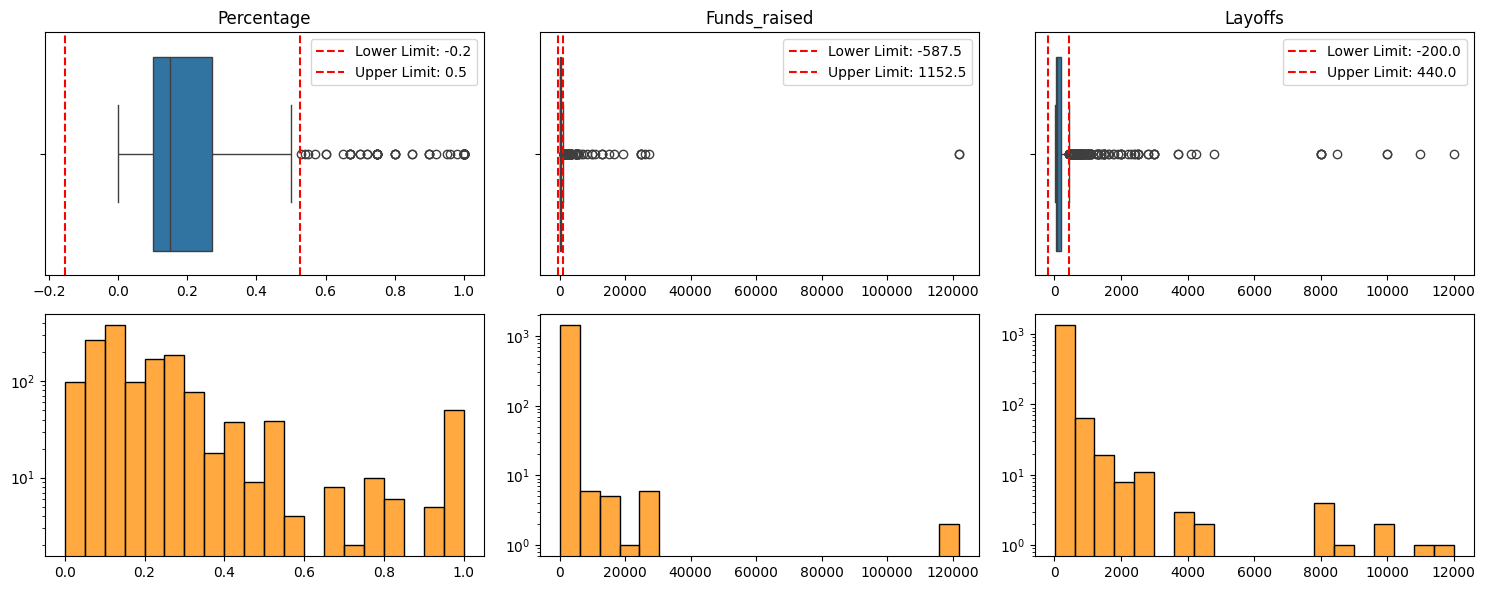

,Column,Number of Outliers,% Outliers,Lower Limit,Upper Limit
0,Percentage,87,5.9,-0.2,0.5
1,Funds_Raised,158,10.8,-587.5,1152.5
2,Layoffs,164,11.2,-200.0,440.0


In [28]:
outlier_col = df.select_dtypes(include = 'float').columns
detect_outliers(df, outlier_col)

In [29]:
df.columns

Index(['Company', 'Location_HQ', 'Industry', 'Percentage', 'Date',
       'Funds_Raised', 'Stage', 'Country', 'Layoffs'],
      dtype='object')

In [30]:
df = df.loc[~(df['Industry'].isin(['Unknown', 'Other']))]

In [31]:
df['Date'] = pd.to_datetime(df['Date'])

<ipython-input-31-b9c6864122be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


In [32]:
df['Year'] = df['Date'].dt.year

<ipython-input-32-e7fb51464c66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year


In [33]:
import altair as alt
from vega_datasets import data

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [51]:
color_scale = alt.Scale(scheme='blues')
selection = alt.selection_single(fields=["Industry"])
bars = alt.Chart(df).mark_bar().encode(
    y=alt.Y('Industry:N', sort='-x', title='Industry'),
    x=alt.X('sum(Layoffs):Q', title='Total Layoffs'),
    color=alt.Color('sum(Layoffs):Q',scale=color_scale),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    tooltip=[alt.Tooltip('Industry:N'), alt.Tooltip('sum(Layoffs):Q', title='Layoffs')]
).properties(
    title="Layoffs by Industry Worldwide"
)


# Add text labels to the bars
text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudge text to the right so it doesn't appear on top of the bar
).encode(
    # text=alt.Text('sum(Layoffs):Q')
)

# Configure overall look of the chart
fancy_bars = (bars + text).add_selection(selection)

# Chart for layoffs by stage
chart_stage = alt.Chart(df).transform_filter(selection).transform_aggregate(
    GroupedLayoffs='sum(Layoffs)',
    groupby=['Stage']
).mark_bar().encode(
    x=alt.X("GroupedLayoffs:Q", title="Layoffs"),
    y='Stage:O'
).properties(
    title="Layoffs stages"
)


layoffs_month = alt.Chart(df).transform_filter(selection).mark_line().encode(
    x='month(Date):T',
    y=alt.Y("sum(Layoffs):Q", title="Total Layoffs")
).properties(
    title="Layoffs by month",
    width=400,
    height=190
)

dashboard = (((fancy_bars)| (chart_stage & layoffs_month))).configure_view(
    strokeWidth=0
)

dashboard

alt.HConcatChart(...)

In [35]:
selection = alt.selection_single(fields=["Industry"], bind='legend',empty='all')

# Define the chart
chart_year = alt.Chart(df).mark_bar().transform_filter(selection).encode(
    row=alt.Row("Industry:O", header=alt.Header(labelAngle=0, labelAlign='left'), spacing=5),
    y=alt.Y('Year:O', title=None, axis=None),
    x=alt.X('sum(Layoffs):Q', title='Total Layoffs', axis=alt.Axis(grid=False)),
    color=alt.Color('Year:O', legend=alt.Legend(title="Year"), scale=alt.Scale(scheme='tableau10')),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    tooltip=[alt.Tooltip('Industry:N'),alt.Tooltip('Year:O'),alt.Tooltip('sum(Layoffs):Q', title='Layoffs')]
).transform_filter(
    alt.FieldOneOfPredicate(field='Year', oneOf=[2022, 2023, 2024])# Filter to include only the years 2022 to 2024
).add_selection(
    selection
).properties(
    height=15,
    title="Layoff by industry of last three years"
# ).configure_view(
#     stroke=None
 )



In [36]:
from IPython.display import display, HTML

industries = [None] + df['Industry'].unique().tolist()
labels = ['All'] + df['Industry'].unique().tolist()
industry_dropdown = alt.binding_select(options=industries, name='Industry: ')

# Define the selection to use the drop-down menu
selection = alt.selection_single(fields=['Industry'], bind=industry_dropdown)

chart_year = alt.Chart(df).mark_bar().encode(
    row=alt.Row("Industry:O", header=alt.Header(labelAngle=0, labelAlign='left'), spacing=5),
    y=alt.Y('Year:O', title=None, axis=None),
    x=alt.X('sum(Layoffs):Q', title='Total Layoffs', axis=None),
    color=alt.Color('Year:O', legend=alt.Legend(title="Year"), scale=alt.Scale(scheme='tableau10')),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    tooltip=[alt.Tooltip('Industry:N'),alt.Tooltip('Year:O'),alt.Tooltip('sum(Layoffs):Q', title='Layoffs')]
).transform_filter(
    alt.FieldOneOfPredicate(field='Year', oneOf=[2022, 2023, 2024])  # Filter to include only the years 2022 to 2024
).add_selection(
    selection
).properties(
    height=alt.Step(8),
    title="Layoff by Industry of Last Three Years"
).configure_view(
    stroke=None
)

display(HTML("""
<style>
form.vega-bindings {
  position: absolute;
  left: 300px;
  top: 0px;
  color: black;
}
</style>
"""))

chart_year

alt.Chart(...)